# <font color='red'>#НЕТ ВОЙНЕ</font>

### Работу лучше смотреть здесь => https://nbviewer.org/github/DmitryShuvalov/ml_intro-7_trees/blob/main/rf_classifier.ipynb, либо на локальном компе в Jupyter Notebook, чтобы лучше рассмотреть результат plot_tree

# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import tests

In [3]:
RANDOM_STATE = 2020

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [4]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=RANDOM_STATE)

# Homework part 1. Implementation of Random Forest Classifier.

## Splitting criteria

**Task 1 - 2 points.** In this section you should implement two criteria for splitting of the feature space. Any of these can be used in the model.

### Gini index

0.5 points for *gini_index* function

In [6]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    x=np.array(x)
    N=x.shape[0]
    if N==0:
        return 0 
    _, counts = np.unique(x, return_counts=True)
    p=counts/N
    return 1-np.sum(p**2)

In [7]:
tests.test_gini_index(gini_index)

 All good!


0.5 points for *gini_gain* function

In [8]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    N=parent_node.shape[0]
    return gini_index(parent_node)-np.sum([gini_index(split)*split.shape[0]/N for split in splits])
    

In [9]:
tests.test_gini_gain(gini_gain)

 All good!


### Entropy

0.5 points for *entropy* function. WARNING! Use only natural logarithm np.log() for calculation.

In [10]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    # If you use vectorized operations on a vector of frequencies p
    # where some of the relative frequencies may be 0, and you need to evaluate
    # the expression p * np.log(p), you can use the "where" argument of the np.log() function.
    # This will leave those elements of the array untouched by the function, 
    # thus evaluating x*log(x) as zero, exactly as we want it to be.
    N=x.shape[0]
    if N==0:
        return 0 
    _, counts = np.unique(x, return_counts=True)
    p=counts/N
    return -np.sum(p*np.log(p))

In [11]:
tests.test_entropy(entropy)

 All good!


0.5 points for *information_gain* function

In [12]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    return entropy(parent_node)-np.sum([entropy(split)*split.shape[0]/parent_node.shape[0] for split in splits])

In [13]:
tests.test_information_gain(information_gain)

 All good!


### <font color='blue'>------------------ЗДЕСЬ РЕШЕНИЯ ДЛЯ ВОПРОСОВ ИЗ ТЕСТА, ГДЕ ТРЕБОВАЛСЯ РАСЧЁТ )) ------------------</font>

In [14]:
print('Question 2:')
x1=np.array([0,0,0])
x2=np.array([0,0,0,1,1,1,1])
x=np.append(x1, x2)
print('Q2. Split1:')
print('Gini gain = ', gini_gain(x,[x1,x2]))
print('Inf gain = ', information_gain(x,[x1,x2]))

x1=np.array([1,1,1,0])
x2=np.array([0,0,0,0,1,0])
x=np.append(x1, x2)

print('Q2. Split2:')
print('Gini gain = ', gini_gain(x,[x1,x2]))
print('Inf gain = ', information_gain(x,[x1,x2]))

print('Результаты противоречивые, так что "Not enough information"')

Question 2:
Q2. Split1:
Gini gain =  0.13714285714285707
Inf gain =  0.19497599371892632
Q2. Split2:
Gini gain =  0.16333333333333339
Inf gain =  0.17774088384195041
Результаты противоречивые, так что "Not enough information"


In [15]:
print('Question 3:')
print('Q3. Split1:')
x1=np.array([0,0])
x2=np.array([0,0,1,1,1,1,1])
x=np.append(x1, x2)
print('Gini gain = ', gini_gain(x,[x1,x2]))
print('Inf gain = ', information_gain(x,[x1,x2]))

print('Q3. Split2:')
x1=np.array([1,1,1])
x2=np.array([0,0,0,0,1,1,1])
x=np.append(x1, x2)
print('Gini gain = ', gini_gain(x,[x1,x2]))
print('Inf gain = ', information_gain(x,[x1,x2]))

print('Результат лучше для Split1. Ответ: Split 1')

Question 3:
Q3. Split1:
Gini gain =  0.1763668430335097
Inf gain =  0.22164078547545663
Q3. Split2:
Gini gain =  0.13714285714285707
Inf gain =  0.19497599371892632
Результат лучше для Split1. Ответ: Split 1


In [16]:
print('Question 6:')
import math
def pr(n,k, p, q):
    x=(k-n*p)/math.sqrt(n*p*q)
    return 1/math.sqrt(2*math.pi*n*p*q) * math.exp(-x*x/2)

res=0
for i in range(17,34,1):
    res += pr(33,i,0.55,0.45)
print(res)
print('Ответ 0.72')

Question 6:
0.7191527866211244
Ответ 0.72


### <font color='blue'>-----------------КОНЕЦ РЕШЕНИЙ ДЛЯ ВОПРОСОВ ИЗ ТЕСТА, ГДЕ ТРЕБОВАЛСЯ РАСЧЁТ-----------------</font>

## Split function

**Task 2 - 1 point** Implement *split_dataset* function. <br>
The rows of the dataframe received by a tree node are split into two dataframes depending on their values in a selected column. Rows with values smaller than the chosen threshold are stored in the resulting left dataframe, and we save rows with values larger than the threshold in the right dataframe. The array with target values should be split in accordance with the feature dataframe.

In [17]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value  #None
    right_mask = X[:, column] > value
    left_y, right_y = split(X[:,column],y, value )#None, None
    left_X, right_X = X[left_mask], X[right_mask] #None, None
    return left_X, right_X, left_y, right_y

In [18]:
tests.test_split_dataset(split_dataset)

 All good!


## Decision tree

**Task 3 - 4.5 points** In the Tree class below you need to complete the *fit(), predict_row()* and *predict()* functions.<br>
Each tree is basically a tree node that may have a left and a right child that are also trees. If a tree doesn't have any child nodes, we call it a leaf.<br>
Since features for splitting a dataframe are chosen randomly, we need a mechanism to control this randomness to aquire reproducibility for testing purposes. In our case we use the [Random Generator](https://numpy.org/doc/stable/reference/random/generator.html)<br>
By creation of a tree only the **criterion** and the **rng** fields are not filled with Nones, so each tree knows what criterion for dataframe splitting it should use. Each fitted tree knows as well by which column and value the split should be performed. If a tree is a leaf it doesn't have information about the split, but stores the predicted value.

In [19]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """
    def __init__(self, criterion='gini', random_gen=None):
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        self.threshold = None           # value of the next split
        self.column_index = None        # column to use for the next split
        self.outcome_probs = None       # the predicted value if the tree is a leaf
        self.left_child = None
        self.right_child = None
        self.rng = random_gen if random_gen is not None else np.random.default_rng()

    @property
    def is_terminal(self):
        """Define is it terminal node."""          
        return not bool(self.left_child and self.right_child)
    
    def _compute_gain(self, y, splits):
        """Compute split gain according to chosen criteria."""
        func = gini_gain if self.criterion == 'gini' else information_gain
        return func(y, splits)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""
        # Sample random subset of features
        subset = self.rng.choice(list(range(0, X.shape[1])), n_features, replace=False)

        max_gain, max_col, max_val = None, None, None
        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self._compute_gain(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain
    
    def _compute_outcome(self, y):
        """Save outcome probabilities for the leaf."""
        self.outcome_probs = np.around(np.sum(y) / y.shape[0])

    def fit(self, X, y, feature_frac=1.0, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array):      The training input samples. 2-dimensional numpy array.
            y (numpy-array):      The target values. 1-dimensional numpy array.
            feature_frac (float): The fraction of features to use when fit is performed. Must be 
                                  between 0.0 and 1.0 (default: 1.0, i.e. all features).
            max_depth (int):      The maximum depth of the tree. If None, then nodes are expanded
                                  until all leaves are pure.
        """
        X=np.array(X)
        y=np.array(y)
        # 3 points
        # Make this tree a leaf and return if max_depth doesn't allow it to grow further
        if max_depth is not None and max_depth==0:
            #print('Лист')
            self._compute_outcome(y)
            return #pass
        
        if not 0.0 <= feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
        # Compute the number of features to use. Should be integer number
        n_features = int(feature_frac*X.shape[1]) #int(None)
        
        # Find the next split    
        column, value, gain = self._find_best_split(X, y, n_features) #None
        
        # Make this tree a leaf and return if the split doesn't bring any gain
        if gain is None or gain==0:
            #print('Лист')
            self._compute_outcome(y)
            return
        
        # Save the necessary information about the next split
        self.threshold = value
        self.column_index = column
        #pass
        
        # Reduce the max_depth parameter for the next tree
        if max_depth is not None:
            max_depth -= 1
            #pass

        # Split dataset
        left_X, right_X, left_target, right_target = split_dataset(X, y, self.column_index, self.threshold)

        # Grow left and right child. Pass over the parent's random generator
        # for reproducible results       
        self.left_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.left_child.fit(X=left_X, y=left_target, feature_frac=feature_frac, max_depth=max_depth)
        #print('left', self.left_child)
        #pass
        
        self.right_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.right_child.fit(X=right_X, y=right_target, feature_frac=feature_frac, max_depth=max_depth)#None
        #print("right", self.right_child)
        #pass

    def predict_row(self, row):
        """Predict single row."""
        # 0.5 points
        
        if not self.is_terminal:
            # Use the stored information about the split to define 
            # if the right or the left child to use
            if row[self.column_index] < self.threshold: #row[None] < None:
                res=self.left_child.predict_row(row) #0.0 #pass
            else:
                res=self.right_child .predict_row(row)#1.0 #pass
        else:
            return self.outcome_probs
        
        return res #None

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        Returns:
            1-dimensional numpy-array with predictions     
        """ 
        # 1 point
        X=np.array(X)
        # Create a numpy array of zeros of necessary length to save predictions
        result = np.zeros(X.shape[0]) #None
        # Go through all rows of the dataset
        for i in range(X.shape[0]):
            # Save the prediction for the current row
            result[i] = self.predict_row(X[i])
            #pass
        return result

In [20]:
tests.test_tree(Tree)

 All good!


**Task 4 - 1 point** Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. **Explain** the results.

In [21]:
%%time
# Your code here
tree_3 = Tree()
tree_3.fit(X=X_train, y=y_train, max_depth=3)
y_3_pred=tree_3.predict(X_test)

Wall time: 2.96 s


In [22]:
%%time
# Your code here
tree_None = Tree()
tree_None.fit(X=X_train, y=y_train, max_depth=None)
y_None_pred=tree_None.predict(X_test)


Wall time: 5.76 s


In [23]:
print('max_depth=3. Accuracy=', accuracy_score(y_test, y_3_pred))
print('max_depth=None. Accuracy=', accuracy_score(y_test, y_None_pred))


max_depth=3. Accuracy= 0.6666666666666666
max_depth=None. Accuracy= 0.6666666666666666


In [24]:
def plot_metrics_on_depths(criterion='gini'):
    max_depths, train_scores, test_scores = [], [], []
    for max_depth in range(0, 8):
        max_depths.append(max_depth)
        model = Tree(criterion=criterion)
        model.fit(X_train.values, y_train.values, max_depth=max_depth)
        train_scores.append(accuracy_score(y_train, model.predict(X_train.values)))
        y_pred = model.predict(X_test.values)
        test_scores.append(accuracy_score(y_test, y_pred))
    res_metrics = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=max_depths)
    sns.set(rc={'figure.figsize':(16, 6)})
    plt.plot(res_metrics['train'], label='train score')
    plt.plot(res_metrics['test'], label='test score')
    plt.title("Accuracy as a function of max_depth")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show();

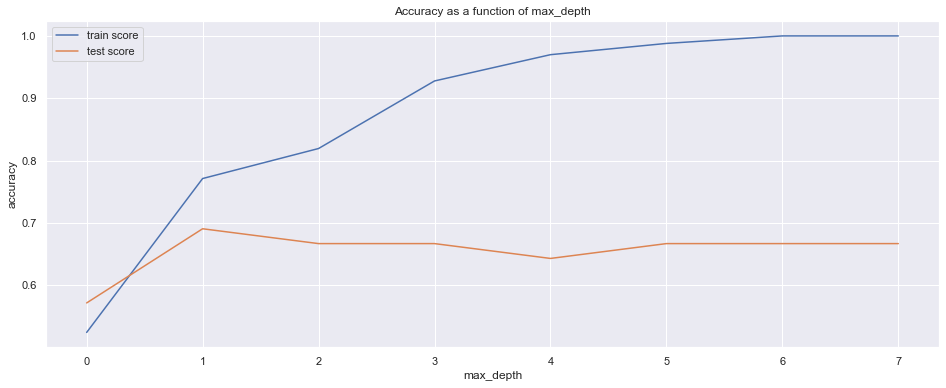

In [25]:
plot_metrics_on_depths('gini')

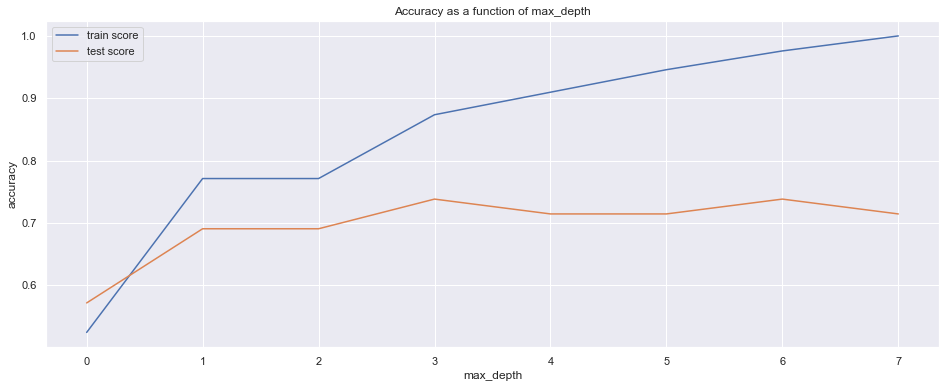

In [26]:
plot_metrics_on_depths('entropy')

##### <font color='red'>Мои мысли</font>
* При критерии "gini" наибольшее значение *accuracy* достигается при *max_depth*=1. При *max_depth*>=2 лучше не становится, несмотря на то, что дерево продолжает строить ветви и листья. Значит, начинается переобучение
* При критерии "entropy" наибольшее значение *accuracy* достигается при *max_depth*=3 или 6. В целом, критерий "энтропия" лучше описывает разбиение на подгруппы

## Random forest

**Task 5 - 1.5 Points** In the RandomForestClassifier class below you need to complete the *fit* and *predict()* functions

In [27]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        feature_frac : float, default=None
            The fraction of features to use when looking for the best split. Must be 
            between 0.0 and 1.0. If None, then `feature_frac = 1 / sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
            
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """

    def __init__(self, n_estimators=10, max_depth=None, feature_frac=None, 
                 criterion="entropy", bootstrap=True, random_gen=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.feature_frac = feature_frac
        
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        
        self.rng = random_gen if random_gen is not None else np.random.default_rng()
        self.trees = [Tree(criterion=self.criterion, random_gen=self.rng) 
                            for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return self.rng.integers(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """
        # 0.5 points
        
        if self.feature_frac is None:
            self.feature_frac = 1 / np.sqrt(X.shape[1])
        elif not 0.0 <= self.feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
            
        self._init_data(X, y)
        
        # Iterate over all trees in the forest
        for tree in self.trees:#None:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            # Fit the tree    
            tree.fit(X=X, y=y, feature_frac=self.feature_frac, max_depth=self.max_depth)
            #pass
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """
        # 1 point
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            # Create a numpy array of zeros of necessary length
            predictions = np.zeros(X.shape[0]) #None
            # Go through all rows of the dataset
            for i in range(X.shape[0]): #None:
                # Initialize a counter for voting
                row_pred = list() #None
                # Sum up predictions from all the voters
                for tree in self.trees:
                    row_pred.append(tree.predict_row(X[i])) #pass
                # Compute the mean of the votes    
                row_pred = np.mean(row_pred)
                # Save the rounded value as the prediction for the current row
                predictions[i] = round(row_pred) #pass
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")
            

In [28]:
tests.test_random_forest(RandomForestClassifier)

 All good!


**Task 6 - 1 Point** Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. **Explain** the results.

In [29]:
%%time
# Your code here
forest_10 = RandomForestClassifier(n_estimators=10)
forest_10.fit(X_train, y_train)
y_f10_pred = forest_10.predict(X_test)
print('n_estimators=10, accuracy_score=', accuracy_score(y_test, y_f10_pred ))

n_estimators=10, accuracy_score= 0.8809523809523809
Wall time: 3.91 s


In [30]:
%%time
# Your code here
forest_100 = RandomForestClassifier(n_estimators=100)
forest_100.fit(X_train, y_train)
y_f100_pred = forest_100.predict(X_test)
print('n_estimators=100, accuracy_score=', accuracy_score(y_test, y_f100_pred ))

n_estimators=100, accuracy_score= 0.8571428571428571
Wall time: 41 s


Now it's your turn to explore the various parameters of RandomForestClassifier and their influence on model quality.

# Homework part 2. Random Forest in action

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

_Note_: For tasks 1 to 5 please use your custom RandomForestClassifier if it is completed.

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [31]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.4, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)

In [32]:
print(X_train.shape, X_test.shape, X_val.shape)

(124, 60) (42, 60) (42, 60)


### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

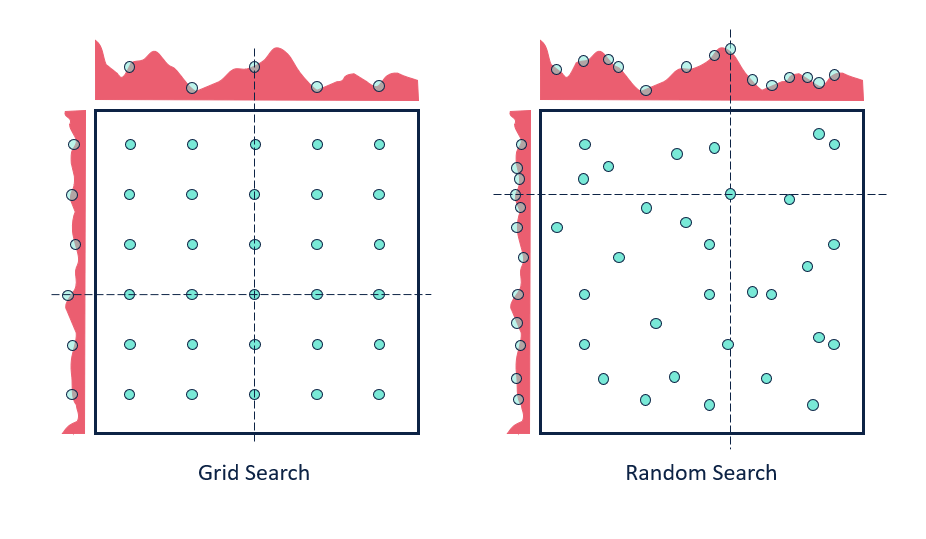

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [33]:
print('Объединим X_train и X_test, y_train и y_test, поскольку это разбиение должно было бы участвовать в Task2, которого нет ))')
X_train = X_train.append(X_test)
y_train = y_train.append(y_test)
print('\n Итог:')
print('X_train size =', X_train.shape, '; y_train size =', y_train.shape[0])
print('X_val size =', X_val.shape, '; y_val size =', y_val.shape[0])


Объединим X_train и X_test, y_train и y_test, поскольку это разбиение должно было бы участвовать в Task2, которого нет ))

 Итог:
X_train size = (166, 60) ; y_train size = 166
X_val size = (42, 60) ; y_val size = 42


In [36]:
# Параметры для построения сетки
criterions = ['gini', 'entropy']
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 5)]
max_features = ['sqrt', 'log2', None]
max_depths = [1, 2, 5, 10, 20] 
min_samples_splits = [2, 5]
min_samples_leafs = [1, 2, 5]
#min_impurity_decreases = [0, 0.1, 0.3, 0.5] #Не использую, так как лучшие результаты получаются при 0
bootstraps = [True, False]
random_states=[10, 20, 30]
params = {'n_estimators': n_estimators,
          'criterion': criterions,
          'max_features': max_features,
          'max_depth': max_depths,
          'min_samples_split': min_samples_splits,
          'min_samples_leaf': min_samples_leafs,
#          'min_impurity_decrease': min_impurity_decreases,
          'bootstrap': bootstraps,
          'random_state': random_states}
params

{'n_estimators': [10, 27, 45, 62, 80],
 'criterion': ['gini', 'entropy'],
 'max_features': ['sqrt', 'log2', None],
 'max_depth': [1, 2, 5, 10, 20],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2, 5],
 'bootstrap': [True, False],
 'random_state': [10, 20, 30]}

In [38]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
forest = RandomForestClassifier()
forest_grid = GridSearchCV(estimator=forest, param_grid=params, cv = 4, verbose=4, n_jobs = -1, scoring='accuracy')

forest_grid.fit(X_train, y_train)

Fitting 4 folds for each of 5400 candidates, totalling 21600 fits
Wall time: 7min 57s


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 5, 10, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 27, 45, 62, 80],
                         'random_state': [10, 20, 30]},
             scoring='accuracy', verbose=4)

In [39]:
import pprint
print('The best train score =', forest_grid.best_score_)
print('The best params:')
pprint.pprint(forest_grid.best_params_)


The best train score = 0.8546747967479675
The best params:
{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 80,
 'random_state': 10}


In [40]:
#Применяем на лучшем эстиматоре
y_grid_pred = forest_grid.best_estimator_.predict(X_val)
accuracy_score(y_val, y_grid_pred)

0.8571428571428571

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [41]:
%%time
# Your code her
# Используем ту же сетку, что и для GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

forest_random = RandomizedSearchCV(estimator = forest, param_distributions = params, n_iter = 500, cv = 4, verbose=1, random_state=42, n_jobs = -1)

forest_random.fit(X_train, y_train)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits
Wall time: 35.6 s


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 27, 45, 62, 80],
                                        'random_state': [10, 20, 30]},
                   random_state=42, verbose=1)

In [42]:
print('The best train score =', forest_random.best_score_)
print('The best params:')
pprint.pprint(forest_random.best_params_)


The best train score = 0.8429152148664343
The best params:
{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 62,
 'random_state': 20}


In [43]:
#Применяем на лучшем эстиматоре
y_random_pred = forest_random.best_estimator_.predict(X_val)
accuracy_score(y_val, y_random_pred)

0.8333333333333334

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

Your cool ideas here...

##### <font color='red'>Мои мысли</font>
* Несмотря на то, что результат у *RandomizedSearchCV* может быть лучше, чем результат у *GridSearch* (что скорее говорит о нестабильности *RandomForestClassifier*), всё же очевидно, что наиболее точный способ получить наилучшую модель - *GridSearch*, поскольку за счёт полного перебора мы проверим все возможные варианты из выбранного нами множества. Однако, время поиска новой модели экспоненциально растёт количеству параметров. Следовательно, либо нужно несколько раз руками сужать и изменять диапазон, либо затратить очень большое количество ресурсов на поиск лучшей модели. 
* Следовательно, целесообразно использовать *RandomizedSearchCV*, который, даже если и не найдёт наилучшую модель, то в любом случае результат будет сопоставим по качеству с полным перебором. 

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [44]:
#Предварительная подготовка данных, чтобы заменить строковые величины на числовые и заполнить пустые поля

def create_new_features(df):
    #Добавим параметр Deck(палуба) на основе первой буквы каюты
    df["Deck"] = df["Cabin"].str.slice(0,1)
    df["Deck"] = df["Deck"].map({"A":1, "B":2, "C":3, "D":4, "E":5, "F":6})
    return df

def fill_na(df, feature, seed=4444):
    dist = df[df[feature].notna()].sort_values(by=[feature]).groupby(feature)[feature].count()
    na_count = df[df[feature].isna()].shape[0]
    np.random.seed(seed)
    df.loc[df[feature].isna(), feature] = np.random.choice(dist.index.values, 
                                                            na_count, 
                                                            p=dist.values/dist.sum())
    return df

def fill_na2(df, feat1, feat2_class, seed=4444):
    classes = df[feat2_class].unique()
    for pclass in classes:
        dist = df[(df[feat1].notna()) & (df[feat2_class]==pclass)].sort_values(by=[feat1]).groupby(feat1)[feat1].count()
        na_count = df[(df[feat1].isna()) & (df[feat2_class]==pclass)].shape[0]
        np.random.seed(4444 + pclass*10)
        df.loc[(df[feat1].isna()) & (df[feat2_class]==pclass), feat1] = np.random.choice(dist.index.values, 
                                                                                         na_count, 
                                                                                         p=dist.values/dist.sum())  
    return df

def fill_na_full(df, seed):
    df = fill_na(df, 'Age', seed) 
    df = fill_na(df, 'Ticket', seed*2)
    df = fill_na(df, 'Embarked', seed*3)
    df = fill_na(df, 'Deck', seed*4)
    df = fill_na2(df, feat1 = 'Fare', feat2_class='Pclass', seed=seed * 5 )
    return df

def full_preprocess(df, target = False):
    df["Sex"] = df["Sex"].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'C': 1, 'S': 2, 'Q': 3})
    df = create_new_features(df)
    df = fill_na_full(df,  seed=6666)
    if target:
        target = df['Survived']
        df = df.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin', 'Age'])
        return df, target
    else:
        df = df.drop(columns=['Name', 'Ticket', 'Cabin', 'Age'])
        return df
        

In [51]:
# your code here
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

PATH = 'data/'
titanic = pd.read_csv(PATH+'train.csv', index_col='PassengerId')

In [52]:
#Обрабатываем датасет 
titanic, titanic_target = full_preprocess(titanic, target=True)
titanic.head(5)

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Deck
PassengerId,,,,,,,
0,1,0,2,0,27.14,2.0,3.0
1,3,0,0,0,13.35,2.0,2.0
2,3,0,1,2,71.29,2.0,1.0
3,3,0,0,0,13.04,2.0,2.0
4,3,0,0,0,7.76,2.0,6.0


In [53]:
X_train, X_test, y_train, y_test = train_test_split(titanic, titanic_target, test_size=0.2, random_state=RANDOM_STATE)

In [54]:
# Параметры для построения сетки
criterions = ['gini', 'entropy']
splitters = ['best', 'random']
max_features = ['sqrt', 'log2', None]
max_depths = [1,  3, 4, 5, 6, 10] 
min_samples_splits = [1, 2, 3, 4, 5]
min_samples_leafs = [1, 2, 3, 5]
min_impurity_decreases = [0] #[0.001] #[0, 0.001, 0.005, 0.01] #При min_impurity_decreases!=0 дерево получается не полным и 
                                                   #поэтому не таким точным, но зато не таким красивым )))))

random_states=[RANDOM_STATE]
params = {'criterion': criterions,
          'splitter': splitters,
          'max_features': max_features,
          'max_depth': max_depths,
          'min_samples_split': min_samples_splits,
          'min_samples_leaf': min_samples_leafs,
          'min_impurity_decrease': min_impurity_decreases,
          'random_state': random_states}
params

{'criterion': ['gini', 'entropy'],
 'splitter': ['best', 'random'],
 'max_features': ['sqrt', 'log2', None],
 'max_depth': [1, 3, 4, 5, 6, 10],
 'min_samples_split': [1, 2, 3, 4, 5],
 'min_samples_leaf': [1, 2, 3, 5],
 'min_impurity_decrease': [0],
 'random_state': [2020]}

In [55]:
%%time
import warnings
warnings.filterwarnings("ignore")
titanic_random = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions = params, n_iter = 2000, verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
titanic_random.fit(X_train, y_train)
#clf = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=6)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
titanic_random.best_params_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Wall time: 1min 17s


{'splitter': 'best',
 'random_state': 2020,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'min_impurity_decrease': 0,
 'max_features': None,
 'max_depth': 5,
 'criterion': 'entropy'}

In [56]:
y_pred = titanic_random.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.7788

Double click, чтобы увеличить картинку дерева
Wall time: 223 ms


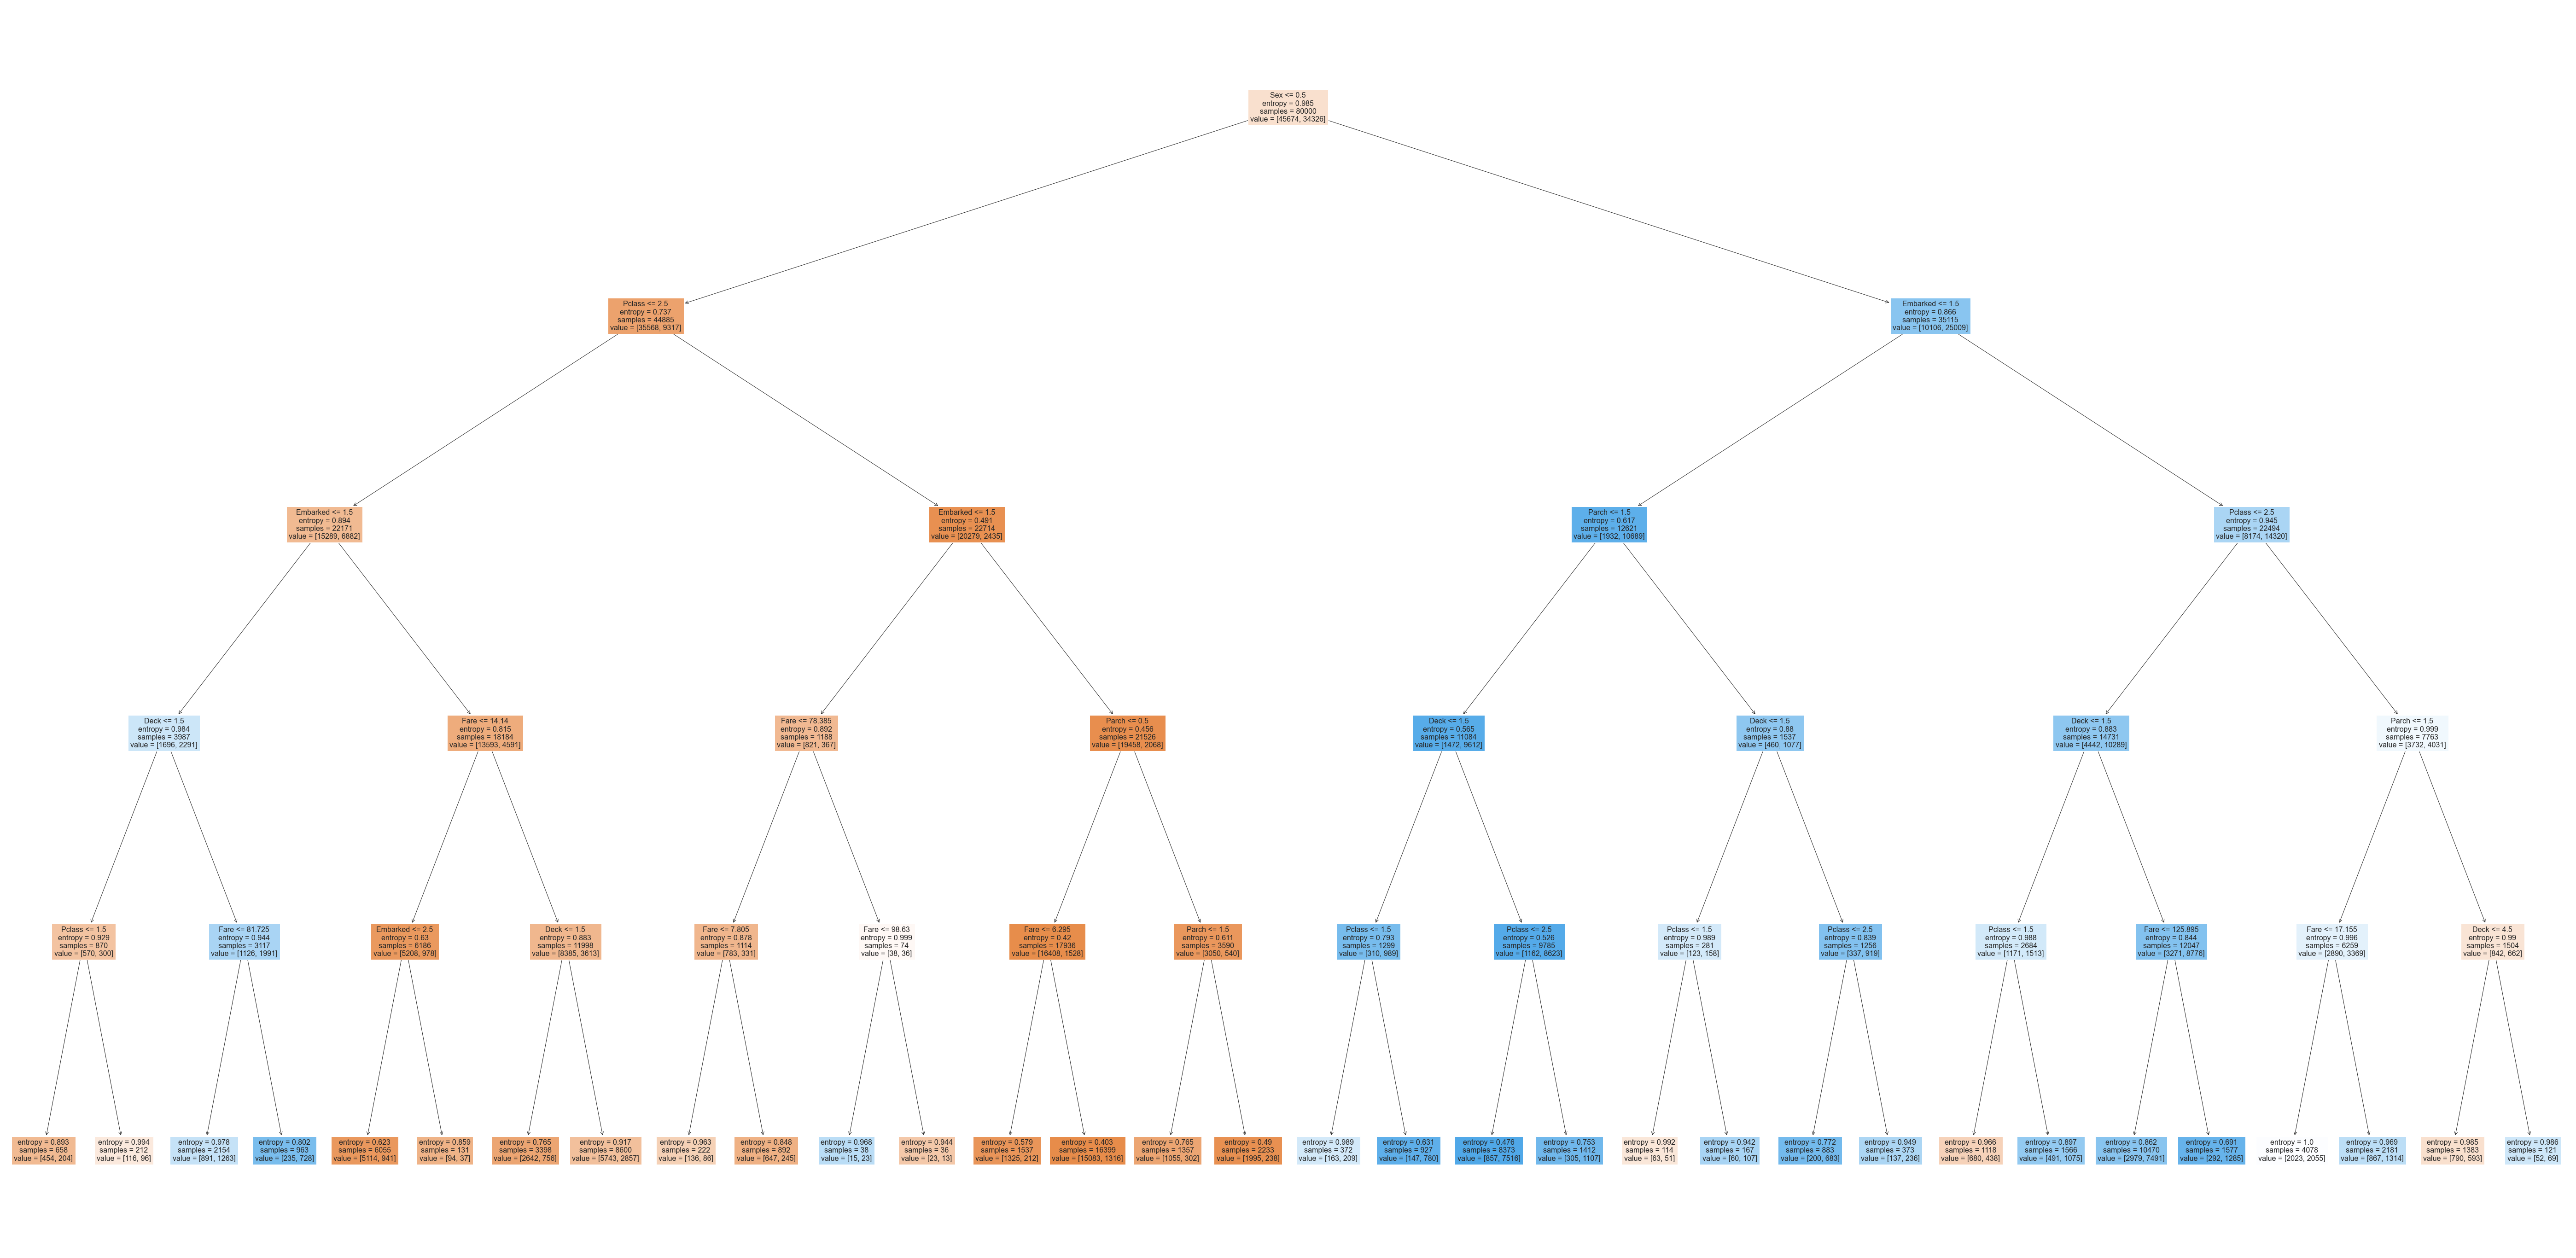

In [57]:
%%time
plt.figure(figsize=(100,50))
tree.plot_tree(titanic_random.best_estimator_, 
               feature_names=X_train.columns,
               filled=True)
print('Double click, чтобы увеличить картинку дерева')

Is it easy to interpret its results? Are you able to explain to a random person why would they survive / die on the titanic?

##### <font color='red'>Мои мысли</font>
* При таком графе, достаточно просто предсказать выживание (с некоторой полученной вероятностью). Отвечая на вопросы узлов DecisionTree за несколько простых шагов можно получить результат. 

## Проверим на тестовом датасете для kaggle

In [58]:
tit_test = pd.read_csv(PATH+'test.csv', index_col='PassengerId')
tit_test = full_preprocess(tit_test, target=False)
tit_test.head(5)

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Deck
PassengerId,,,,,,,
100000,3,0,0,0,63.01,2.0,1.0
100001,3,1,0,0,5.81,2.0,1.0
100002,1,1,0,0,38.91,1.0,2.0
100003,2,0,0,0,12.93,2.0,1.0
100004,1,1,0,2,26.89,1.0,2.0


In [59]:
tit_test_pred = titanic_random.best_estimator_.predict(tit_test)
res_df = pd.DataFrame({'PassengerId' : tit_test.index.values, 'Survived' : tit_test_pred}).set_index('PassengerId')
res_df.to_csv("titanic_tree.csv")

## Результат на Kaggle - Public score: 0.79086 (файл csv находится в репозитории)
https://github.com/DmitryShuvalov/ml_intro-7_trees/blob/main/titanic_tree.csv

##### <font color='red'>Мои мысли</font>
* Оказалось, что DecisionTree даёт точность, сопоставимую с линейной регрессией. При этом за счёт использования RandomizedSearchCV время обучения невелико. Скорость predict также высока, за счёт очень простого алгоритма.